# Initialization

In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
import os
import pickle
from openai import OpenAI
from dotenv import load_dotenv
from nodes import network_gathering_node, graph_and_exploitation_inference_node, exposure_manager_node, firewall_node, save_iteration_node, node_utils
from configuration.state import AgentState
from configuration import memory
from prompts import firewall_executor_prompt
nest_asyncio.apply()

import benchmark.benchmark as b


def display_graph(graph, width=300, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=node_utils.OPEN_AI_KEY)
        response = client.chat.completions.create(
            model="gpt-4.1-mini",
            messages=[{"role":"system", "content":"ciao"}],
            )
        print(response.choices[0].message.content)
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:
# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key    
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ciao! Come posso aiutarti oggi?
API key is valid: True


In [3]:
def should_continue_from_firewall(state: AgentState) -> Literal["tools_firewall", "persistence_node"]:
    if hasattr(state, 'firewall_action'):
        return "tools_firewall"
    
    return "persistence_node"

In [4]:
def build_graph():
    graph = StateGraph(AgentState)
    
    graph.add_node("network_info_gathering", network_gathering_node.network_gathering)
    graph.add_node("graph_inference", graph_and_exploitation_inference_node.graph_and_exploitation_inference)
    graph.add_node("exposure_manager", exposure_manager_node.exposure_manager)
    graph.add_node("firewall_manager", firewall_node.firewall_executor)
    graph.add_node("persistence_node", save_iteration_node.save_iteration)
    graph.add_node("tools_firewall", firewall_node.tools_firewall)

    # Define execution order
    graph.add_edge(START, "network_info_gathering")
    graph.add_edge("network_info_gathering", "graph_inference") 
    graph.add_edge("graph_inference", "exposure_manager")
    graph.add_edge("exposure_manager", "firewall_manager")
    graph.add_conditional_edges("firewall_manager", should_continue_from_firewall)
    graph.add_edge("tools_firewall", "persistence_node")
    graph.add_edge("persistence_node", END)

    return graph.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:42651/devtools/browser/6e8717fe-c2d5-466b-a4ee-66ff41b7eb3e
INFO:pyppeteer.launcher:terminate chrome process...


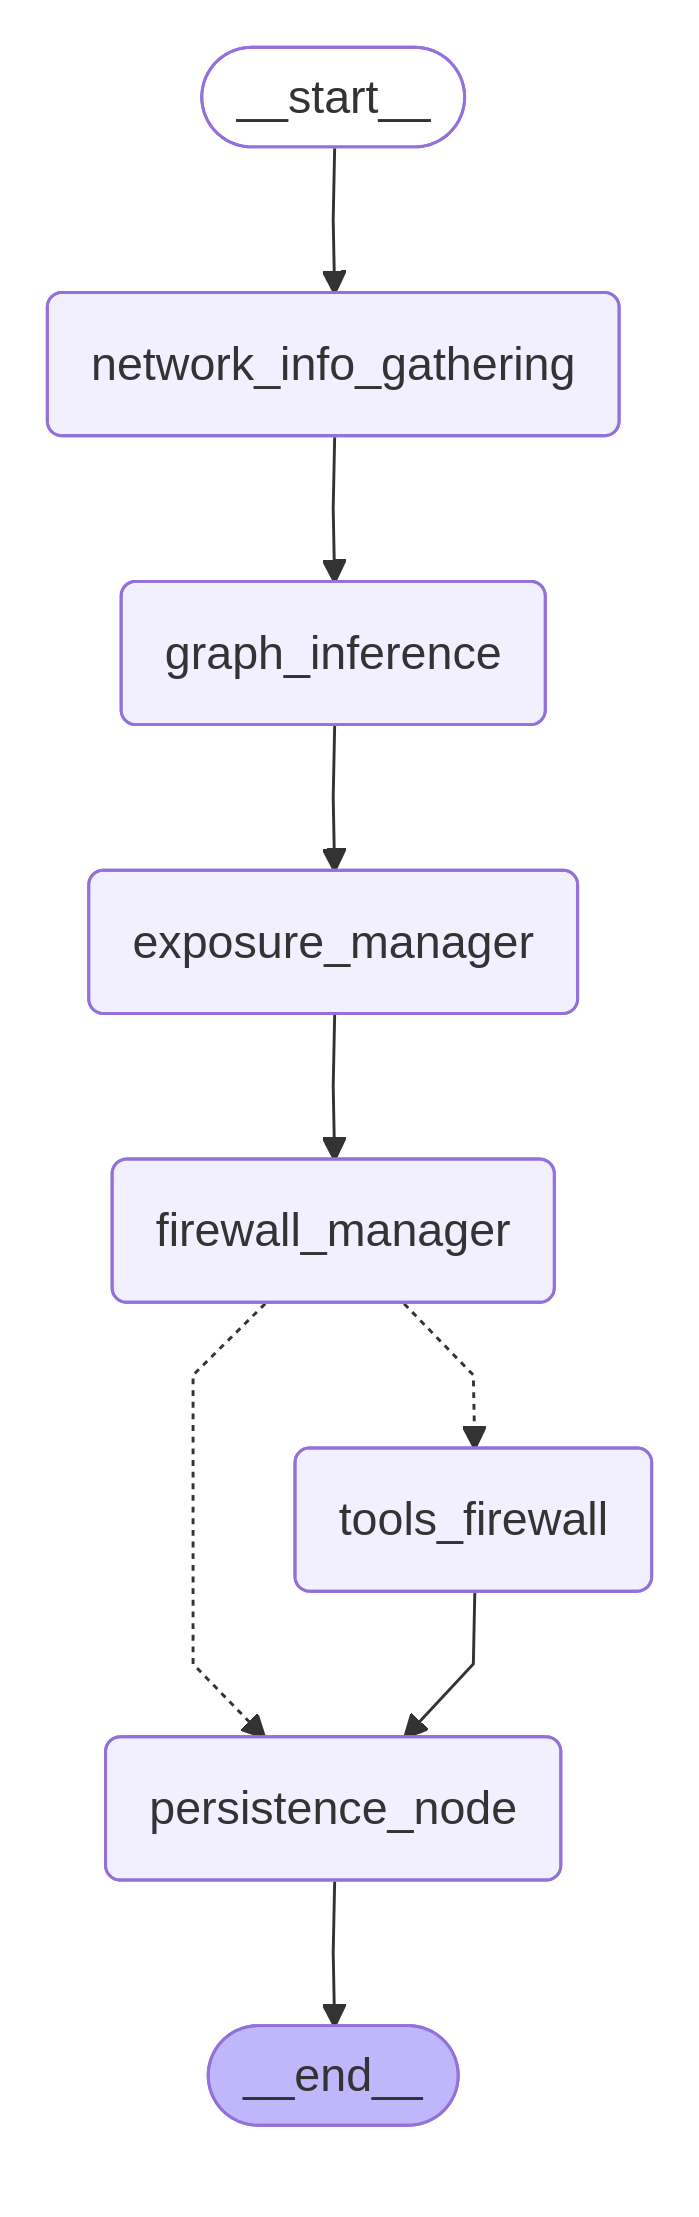

In [5]:
graph = build_graph()
display_graph(graph)

## Single Iteration

In [6]:
# episodic_memory = memory.EpisodicMemory()

In [7]:
# responses = []
# for i in range(1):
#     initial_state = AgentState(
#         messages=[]
#     )
#     response = await graph.ainvoke(initial_state, config={"configurable": {"store" : episodic_memory, "prompt":"eve", "time_window":5, "epoch_num":i+1, "model_config":"llama4:maverick"}})
#     responses.append(response)

In [8]:
# for response in responses:
#     for m in response['messages']:
#         m.pretty_print()

# Benchmark

In [12]:
modes = {
    "cons" : "consecutive",
    "det" : "deterministic",
    "prob" : "probabilistic"
}

episodic_memory = memory.EpisodicMemory()
dir_name = "test_3"

config_dict = {
            "max_epochs": 20,
            "attack_duration": 240,
            "monitor_accumulation_wait": 5,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": dir_name,
            "mode": modes["cons"]
        }
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = AgentState(
    messages=[]
)
responses = []
async def my_agent_executor(epoch_num: int):
    response = await graph.ainvoke(initial_state, config={
        "configurable": 
            {
            "store" : episodic_memory, 
            "time_window":2, 
            "prompt":"eve",
            "epoch_num": epoch_num,
            "model_config": "gpt-4.1-mini"
            }
        }
    )
    responses.append(response)
    return response
    

results = runner.run(my_agent_executor)
with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "wb") as f:
    pickle.dump(responses, f)

INFO:benchmark.benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.benchmark.Orchestrator:
INFO:benchmark.benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.benchmark.Orchestrator:============================================================

INFO:benchmark.benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.benchmark.Orchestrator:Starting attacker script with a fallback timeout of 240s...
INFO:benchmark.benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1', 'consecutive']
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark

# Printing Responses

In [10]:
for i, response in enumerate(responses):
    
    print("=" * 130)
    print(f"Epoch: {i+1}")
    for m in response['messages']:
        m.pretty_print()
    print("-" * 130)

In [11]:
# dir_name = 'test_4'
# with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "rb") as f:
#     saved_responses = pickle.load(f)

# for i, res in enumerate(saved_responses):
#     print(f"Epoch {i+1}")
#     for m in res["messages"]:
#         m.pretty_print()